In [1]:
%matplotlib inline

from matplotlib import pyplot
import geopandas as gpd

from tile_units import TileUnit
from tile_map import Tiling

In [2]:
ak = gpd.read_file("../data/imd-auckland-2018.gpkg")

# Cairo tiles [3<sup>2</sup>.4.3.4]
The one true tiling. Provides 4 directionally distinguishable elements... and also can be read two different ways (intersecting hexagons runninng in two orthogonal directions).

<AxesSubplot:>

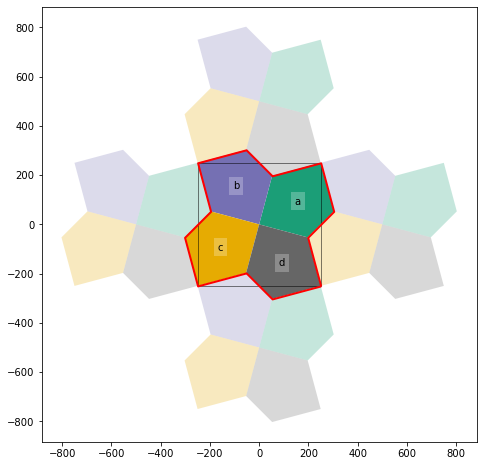

In [3]:
tile_unit = TileUnit(tiling_type = "laves", code = "3.3.4.3.4",
                     spacing = 500, crs = ak.crs)
tile_unit.plot(r = 1)

In [4]:
tiling = Tiling(tile_unit, ak, id_var = "DZ2018")

In [5]:
t30 = tiling.get_tiled_map(prioritise_tiles = True)

(<AxesSubplot:>, <Axes:label='inset_axes'>)

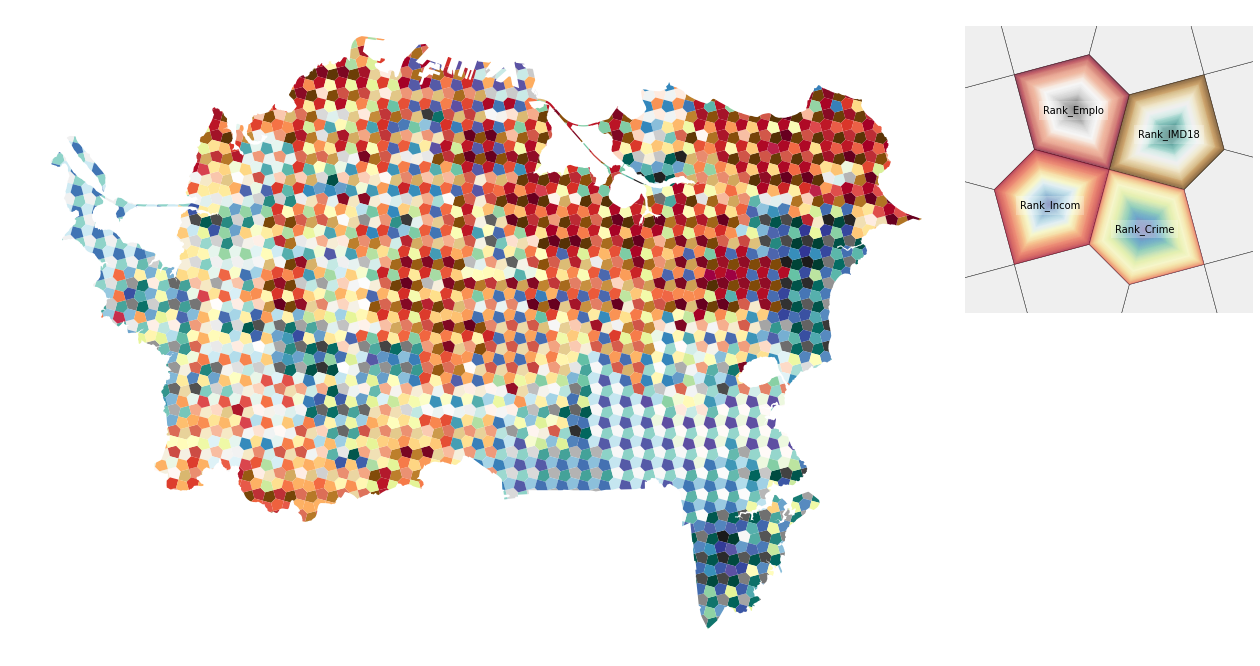

In [6]:
fig = pyplot.figure(figsize = (20, 12))

ids = sorted(list(set(t30.element_id)))
cols = dict(zip(ids, [x for x in t30.columns if "Rank" in x]))
cmaps = dict(zip(ids, ("BrBG", "RdGy", "RdYlBu", "Spectral", 
                       "PiYG", "PRGn", "PuOr", "viridis")))

tiling.plot_map(fig, t30, cols, cmaps, legend = True)